# **TREC-COVID Query Analysis**

In this notebook I will be conducting query analysis in order to understand the types of queries made available in TREC-COVID.

## **Setup**

In [ ]:
!pip install --upgrade python-terrier

     |████████████████████████████████| 97 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 69 kB 6.2 MB/s 
     |████████████████████████████████| 255 kB 52.1 MB/s 
     |████████████████████████████████| 41 kB 272 kB/s 
     |████████████████████████████████| 596 kB 39.8 MB/s 
     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 126 kB 43.9 MB/s 
     |████████████████████████████████| 294 kB 51.2 MB/s 
     |████████████████████████████████| 1.8 MB 51.4 MB/s 
     |████████████████████████████████| 6.4 MB 57.1 MB/s 
     |████████████████████████████████| 291 kB 53.7 MB/s 
     |████████████████████████████████| 59 kB 7.2 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none-any.whl size=103883 sha256=76d0e03a1b7845a2b07cf1b08bbae7d0a45eb64ddde8b69a5f5919385d6e27da
  Stored in directory: /root/.cac

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics('title')

/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [ ]:
topics = list(topics['query'])

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 24.3 MB/s 
     |████████████████████████████████| 6.8 MB 54.1 MB/s 
     |████████████████████████████████| 895 kB 59.1 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the Tokenizer and Sequence Classification model from the HuggingFace repo
# Both are based on microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract with
# fine-tuning on the model for this topic/article type prediction task
tokenizer = AutoTokenizer.from_pretrained("jakelever/coronabert")
model = AutoModelForSequenceClassification.from_pretrained("jakelever/coronabert")

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/220k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
classifications = []

for topic in topics:

  text = [topic]
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=500)
  outputs = model(**inputs)
  scores = outputs.logits[0,:].tolist()
  from scipy.special import expit
  scores = expit(scores)
  scores = outputs.logits[0,:].tolist()
  from scipy.special import expit
  scores = expit(scores)
  scores_with_labels = [ (s,model.config.id2label[i]) for i,s in enumerate(scores) ]
  classifications.append(sorted(scores_with_labels, reverse=True))

In [ ]:
top_classifications = []
for classification in classifications:
  top_classifications.append(classification[0][1])


In [ ]:
x_labels = list(pd.DataFrame(top_classifications).value_counts().index)
y_values = list(pd.DataFrame(top_classifications).value_counts().values)
refined_x = []
for label in x_labels:
  refined_x.append(label[0])

## **Results**

Text(0, 0.5, 'Number of Queries')

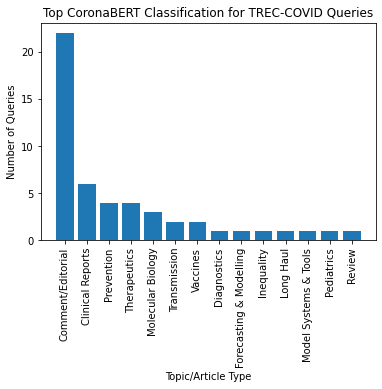

In [ ]:
plt.bar(refined_x, y_values)
plt.xticks(rotation=90)
plt.title('Top CoronaBERT Classification for TREC-COVID Queries')
plt.xlabel('Topic/Article Type')
plt.ylabel('Number of Queries')